<a href="https://colab.research.google.com/github/Ayikanying-ux/Getting_started_-with_deep_learning/blob/main/basic_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basic training loops
* In the previous guides, you have learned about tensors, variables, gradient tape and modules. In this guide, you will fit these all together to train models.
* TensorFlow also incluedes the tf.keras API, a high-level neural network API that provides useful abstractions to reduce boilerplate. However in this guide, you will use basic classes

### Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Solvin machine learning problems
Solving a machine learning problem usually consists of the following steps
- Obtain training data
- Define the model
- Define a loss function
- Run through the training data, calculating loss from the ideal value
- Calculate gradients for that loss and use an optimizer to adjust the variable to fit the data
- Evaluate your results.

For illustration purposes, in this guide you'll develop a simple linear model, f(x) = x * W + b, which has two variables: W (weights) and b (bias).

This is the most basic machine learning problems: Given x and y, try to find the slope and offset of a line via simple linear regression.

### Data
* Supervised learning uses inputs (usually denoted as x) and outputs (denoted y, often called labels). The goal is to learn from paired inputs an outpust so that you can predict the value of an output from an input.
* Each input of your data, in TensorFlow, is almost always represented by a tensor, and is often a vector. In supervised training, the output (or value you'd liked to predict) is also a tensor.
* Here si some data synthensized by adding Gaussian (Normal) noise to points along a line.


In [2]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0


NUM_EXAMPLES = 201


# A vector of random x values
x = tf.linspace(-2,2, NUM_EXAMPLES)
x = tf.cast(x, tf.float32)

def f(x):
  return x * TRUE_W + TRUE_B

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = f(x) + noise

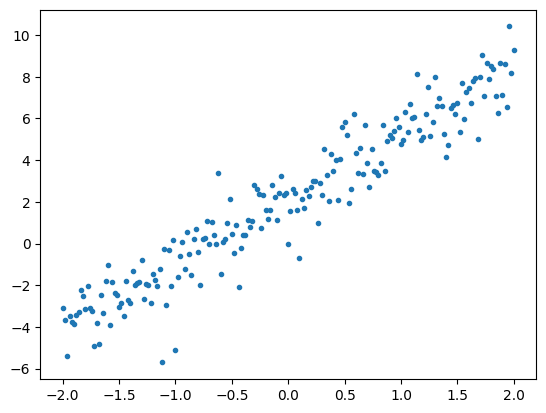

In [3]:
# Plot all the data
plt.plot(x, y, '.')
plt.show()



---
* Tensors are usually gathered together in batches, or groups of inputs and outputs stacked together. Batching can confer some training benefits and works well with accelerators and vectorized computation. Given how small this dataset is, you can treat the entire dataset as a single batch.


### Define the model
* Use tf.Variable to represent all weights in a model. A tf.Variable stores a value and provides this in tensor form as needed. See the variable guide for more details.
* Use tf.Module to encapsulate the variables and the computation. You could use any Python object, but this way it can be easily saved

In [4]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


### Define a loss fuction
* A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Define the standard L2 loss, also known as the "mean squared" error:

In [5]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

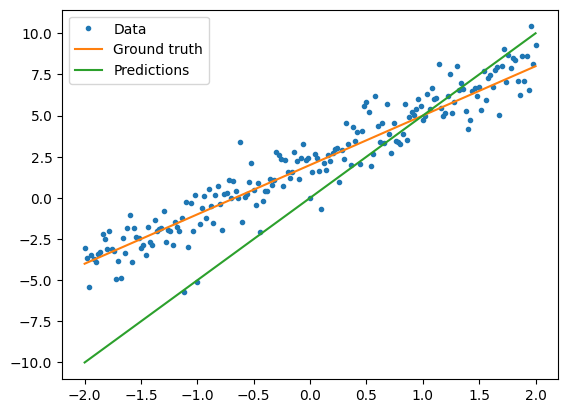

Current loss: 10.427697


In [6]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(y, model(x)).numpy())

### Define a training loop
The training loop consits of repeatedly doing three tasks in order
- Sending a batch of inputs through the model to generate output
- Calculating the loss by comparing the outputs to the output (or label)
- Using gradient tape to find the gradients
- Optimizing the variables with those gradient

For this example, you can train the model using gradient descent.

There are many variants of the gradient descent scheme that are captured in ```tf.keras.optimizers```. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of ```tf.GradientTape``` for automatic differentiation and ```tf.assign_sub``` fo decrementing a value (which combines ```tf.assign``` and ```tf.sub```)

In [7]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

In [8]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
weights = []
biases = []
epochs = range(10)

# Define a training loop
def report(model, loss):
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"


def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print(f"Epoch {epoch:2d}:")
    print("    ", report(model, current_loss))

In [9]:
current_loss = loss(y, model(x))

print(f"Starting:")
print("    ", report(model, current_loss))

training_loop(model, x, y)

Starting:
     W = 5.00, b = 0.00, loss=10.42770
Epoch  0:
     W = 4.49, b = 0.42, loss=6.60042
Epoch  1:
     W = 4.12, b = 0.76, loss=4.38788
Epoch  2:
     W = 3.85, b = 1.03, loss=3.09834
Epoch  3:
     W = 3.65, b = 1.24, loss=2.34057
Epoch  4:
     W = 3.51, b = 1.42, loss=1.89164
Epoch  5:
     W = 3.40, b = 1.55, loss=1.62358
Epoch  6:
     W = 3.32, b = 1.66, loss=1.46229
Epoch  7:
     W = 3.27, b = 1.75, loss=1.36455
Epoch  8:
     W = 3.23, b = 1.82, loss=1.30493
Epoch  9:
     W = 3.20, b = 1.88, loss=1.26833


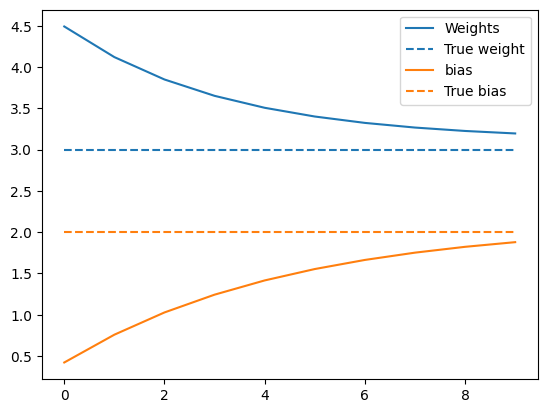

In [10]:
plt.plot(epochs, weights, label='Weights', color=colors[0])
plt.plot(epochs, [TRUE_W] * len(epochs), '--',
         label = "True weight", color=colors[0])

plt.plot(epochs, biases, label='bias', color=colors[1])
plt.plot(epochs, [TRUE_B] * len(epochs), "--",
         label="True bias", color=colors[1])

plt.legend()
plt.show()

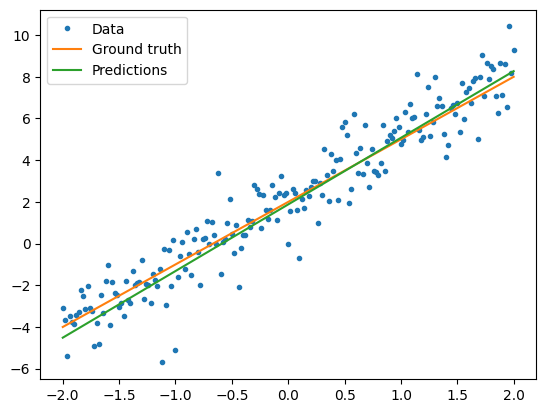

Current loss: 1.268332


In [11]:
plt.plot(x, y, '.', label="Data")
plt.plot(x, f(x), label="Ground truth")
plt.plot(x, model(x), label="Predictions")
plt.legend()
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

### The same solution, but with Keras

In [12]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x):
    return self.w * x + self.b

keras_model = MyModelKeras()

# Reuse the training loop with a Keras model
training_loop(keras_model, x, y)

# You can also save a checkpoint using Keras's built-in support
keras_model.save_weights("my_checkpoint")

Epoch  0:
     W = 4.49, b = 0.42, loss=6.60042
Epoch  1:
     W = 4.12, b = 0.76, loss=4.38788
Epoch  2:
     W = 3.85, b = 1.03, loss=3.09834
Epoch  3:
     W = 3.65, b = 1.24, loss=2.34057
Epoch  4:
     W = 3.51, b = 1.42, loss=1.89164
Epoch  5:
     W = 3.40, b = 1.55, loss=1.62358
Epoch  6:
     W = 3.32, b = 1.66, loss=1.46229
Epoch  7:
     W = 3.27, b = 1.75, loss=1.36455
Epoch  8:
     W = 3.23, b = 1.82, loss=1.30493
Epoch  9:
     W = 3.20, b = 1.88, loss=1.26833




---
* Rather than write new training loops each time you create a model, you can use the built-in features of Keras as a shortcut. This can be useful when you do not want to write or debug Python training loops.

* If you do, you will need to use model.compile() to set the parameters, and model.fit() to train. It can be less code to use Keras implementations of L2 loss and gradient descent, again as a shortcut. Keras losses and optimizers can be used outside of these convenience functions, too, and the previous example could have use

In [13]:
keras_model = MyModelKeras()

# compile sets the training parameters
keras_model.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=tf.keras.losses.mean_squared_error,
)



---
* Keras fit expects batched data or a complete dataset as a NumPy array. NumPy arrays are chopped into batches and default to a batch size of 32.

* In this case, to match the behavior of the hand-written loop, you should pass x in as a single batch of size 1000.


In [14]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)

201
Epoch 1/10
1/1 [==============================] - 0s 491ms/step - loss: 10.4277
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 6.6004
Epoch 3/10
1/1 [==============================] - 0s 20ms/step - loss: 4.3879
Epoch 4/10
1/1 [==============================] - 0s 15ms/step - loss: 3.0983
Epoch 5/10
1/1 [==============================] - 0s 12ms/step - loss: 2.3406
Epoch 6/10
1/1 [==============================] - 0s 22ms/step - loss: 1.8916
Epoch 7/10
1/1 [==============================] - 0s 18ms/step - loss: 1.6236
Epoch 8/10
1/1 [==============================] - 0s 17ms/step - loss: 1.4623
Epoch 9/10
1/1 [==============================] - 0s 21ms/step - loss: 1.3646
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 1.3049
